<a href="https://colab.research.google.com/github/Jorbnc/MAIA-UL/blob/main/Mini-Proyecto%201%20DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

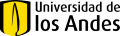

<span style="font-family:Cambria Math">
    
# Examen Final: Clasificación de la Calidad del Vino - *Machine Learning* Supervisado

## Descripción del problema:

La industria de vinos busca constantemente mejorar la calidad de sus productos. Un modelo de clasificación de calidad del vino permitiría identificar qué características fisicoquímicas afectan la percepción de calidad y ayudaría a optimizar el proceso de producción. El objetivo de este examen es diseñar un clasificador que prediga la calidad del vino basado en sus características químicas.

## Objetivo:
El propósito de este examen es evaluar el cumplimiento de los objetivos de aprendizaje planteados al comienzo del curso:

- Identificar problemas que se pueden resolver usando *Machine Learning* supervisado.
- Implementar una solución de *machine learning* supervisado a problemas prácticos.
- Evaluar el desempeño de modelos de *machine learning* supervisado
</span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**Este proyecto es realizado por Andrés Felipe Ñungo para entrega el 14 de marzo.**
</div24></span>

<span style="font-family:Cambria Math">

***
    
# Índice
Este examen se compone de las siguientes secciones:

1. [Instalación y carga de librerías](#instalacion-y-carga-de-librerias)
2. [Análisis exploratorio y preparación de los datos](#analisis-exploratorio-y-preparacion-de-los-datos)
3. [Limpieza y definición de *pipelines* de preprocesamiento](#limpieza-y-definicion-de-pipelines-de-preprocesamiento)
   - [Análisis de la distribución de los datos](#analisis-de-la-distribucion-de-los-datos)
   - [*Pipeline* de preprocesamiento](#pipeline-de-preprocesamiento)
4. [Entrenamiento de los modelos y búsqueda de hiperparámetros](#entrenamiento-de-los-modelos-y-busqueda-de-hiperparametros)
   - [Modelo: Regresión Logística](#modelo-regresion-logistica)
   - [Modelo: Perceptrón Multicapa](#modelo-perceptron-multicapa)
   - [Modelo: K-Vecinos](#modelo-k-vecinos)
   - [Modelo: Árbol de Decisión](#modelo-arbol-de-decision)
   - [Modelo: Random Forest](#modelo-random-forest)
   - [Modelo: Máquinas de Vectores de Soporte](#modelo-maquinas-de-vectores-de-soporte)
   - [Modelo: XGBoost](#modelo-xgboost)
5. [Evaluación del modelo: Comparación de rendimiento](#evaluacion-del-modelo-comparacion-de-rendimiento)
6. [Análisis de resultados y conclusiones](#analisis-de-resultados-y-conclusiones)
   - [Ejercicio Didáctico: Uso de la Cota de Chernoff](#ejercicio-didactico-uso-de-la-cota-de-chernoff)
7. [Referencias](#referencias)
</span>

***

<span style="font-family:Cambria Math">

# 1. Instalación y cargue de librerías
</span>

***

<span style="font-family:Cambria Math">

En primer lugar se empieza por la descarga de las librerias usadas en este *notebook*. Adicionalmente, se hace explícita las versiones usadas para poder replicar este trabajo más adelante.
</span>

In [ ]:
!pip install ydata-profiling imbalanced-learn xgboost scikit-learn matplotlib seaborn

In [ ]:
#Importar librerias necesarias

#Librias básicas
import numpy as np
import pandas as pd
import time
from random import random, seed
from scipy.stats import uniform, randint
from google.colab import files

#Preparación y exploración
from IPython.core.display import display
from ydata_profiling import ProfileReport
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

#Modelos de clasificación
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#Librerias de Evaluación
from sklearn.metrics import confusion_matrix, accuracy_score , precision_recall_curve, roc_auc_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold

#Librerias de Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [ ]:
#Visulización adecuada de gráficas en notebook
%matplotlib inline

In [ ]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from importlib.metadata import version
#Librerias usadas
librerias = ['pandas', 'numpy', 'scikit-learn', 'seaborn', 'matplotlib',
             'xgboost', 'ydata-profiling', 'imbalanced-learn', 'scipy', 'joblib']
for library in librerias:
  print(library, ": ", version(library))

pandas :  2.2.2
numpy :  1.26.4
scikit-learn :  1.6.1
seaborn :  0.13.2
matplotlib :  3.10.0
xgboost :  2.1.4
ydata-profiling :  4.14.0
imbalanced-learn :  0.13.0
scipy :  1.14.1
joblib :  1.4.2


In [ ]:
#Definición del random state usado en los pseudo-aleatorios
RANDOM_STATE = 13

***
<span style="font-family:Cambria Math">

# 2. Análisis exploratorio y preparación de los datos

Como es usual en el ciclo de ejecución de un proyecto de *Machine Learning* es fundamental hacer una análisis exploratorio que permita identificar inconsistencias en la información, y dar una noción de cómo se distribuyen los datos. A continuación, se construyen algunas gráficas y se calculan estadísticas que permiten conocer a profundidad la información y hacer los ajustes requeridos antes del pre-procesamiento.
</span>

In [ ]:
data_raw = pd.read_csv('sample_data/wine_quality.csv').drop(columns='Unnamed: 0')
data_raw.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
data_raw.shape

(6497, 12)

In [ ]:
data_raw.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


***
<span style="font-family:Cambria Math">

El análisis preliminar revela que los datos están completos, con **6,497** registros en cada columna. Además, todas las variables son numéricas.

A simple vista, no se identifican *outliers* ni valores erróneos. Sin embargo, se continuará con un análisis exploratorio más detallado para asegurarse de que no haya patrones inusuales o inconsistencias en los datos.
</span>

In [ ]:
# Print de datos errados
print(f'Nulos:\n{data_raw.isna().sum()}')

Nulos:
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [ ]:
# Print de datos duplicados
print(f'Duplicados: {data_raw.duplicated().sum()}')

Duplicados: 1179


***
<span style="font-family:Cambria Math">

Se identificaron **1,179** registros duplicados en la base de datos. Dado que los *features* son numéricos y continuos, es altamente improbable que esta duplicidad sea producto de una coincidencia.

Por lo tanto, en la sección de Limpieza y Preparación de los Datos, será necesario eliminar estos duplicados para garantizar la calidad del conjunto de datos.

</span>

In [ ]:
# Se calcula el rango intercuartil y se determinan los outliers por variable
Q1 = data_raw.quantile(0.25)
Q3 = data_raw.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data_raw < (Q1 - 1.5 * IQR)) | (data_raw > (Q3 + 1.5 * IQR)))
total = outliers.sum()
print(total)

fixed_acidity           357
volatile_acidity        377
citric_acid             509
residual_sugar          118
chlorides               286
free_sulfur_dioxide      62
total_sulfur_dioxide     10
density                   3
pH                       73
sulphates               191
alcohol                   3
quality                 228
dtype: int64


***
<span style="font-family:Cambria Math">

Al analizar los rangos intercuartílicos [¹], se observa que la mayoría de las variables presentan una cantidad significativa de datos situados por encima del percentil 75% o por debajo del 25%. Esto sugiere una distribución dispersa, con colas alargadas en la mayoría de las columnas.

Sin embargo, las variables **`alcohol`** y **`density`** exhiben datos aislados que podrían representar posibles *outliers*.
</span>

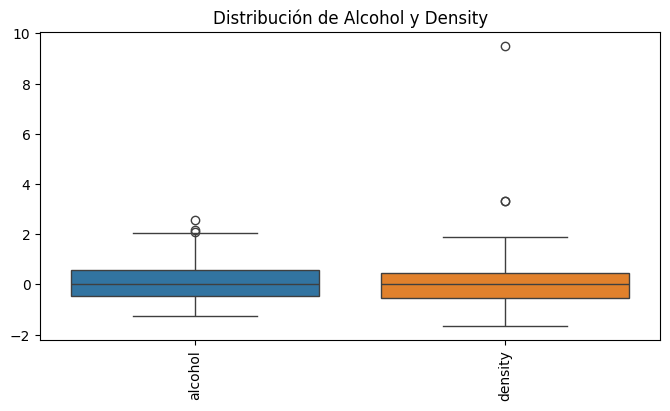

In [ ]:
columnas = ["alcohol", "density"]

scaler_temp = RobustScaler()
data_scaled = pd.DataFrame(scaler_temp.fit_transform(data_raw[columnas]), columns=columnas)

# Crear el boxplot con los datos escalados
plt.figure(figsize=(8, 4))
sns.boxplot(data=data_scaled)
plt.xticks(rotation=90)
plt.title("Distribución de Alcohol y Density")
plt.show()

***
<span style="font-family:Cambria Math">

Se observa que las variables **`density`** y **`alcohol`** podrían contener valores significativamente alejados del resto de los datos. En particular, el máximo valo de `density` es **1.038**, mientras que en `alcohol` alcanza **14.9**.

Para determinar si estos valores deben considerarse *outliers* y eliminarse, se analizarán sus histogramas más adelante. No obstante, en este punto aún es prematuro concluir que deben ser eliminados.

Además, utilizamos la función **`ProfileReport`** [²] para obtener una visión más completa de la base de datos y facilitar el análisis exploratorio.
</span>

In [ ]:
# Reporte EDA version HTML (No se deja embebido porque luego no me permite exportar el reporte en formato HMTL correctamente :( )
profile = ProfileReport(data_raw, title="Profiling Report", explorative=True)
html_filename = "EDA_Profiling_Report.html"
profile.to_file(html_filename)
files.download(html_filename)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

***
<span style="font-family:Cambria Math">

El reporte de **Análisis Exploratorio de Datos (EDA)** revela varios puntos importantes:

- La mayoría de las *features* presentan una cantidad relativamente baja de valores únicos. Esto sugiere que, en el caso de los vinos, estas características pueden estar delimitadas a un conjunto de valores fijos.
- La variable **`citric_acid`** tiene múltiples valores en cero, lo cual podría deberse a propiedades intrínsecas del vino. Es decir, algunos vinos pueden no contener esta característica.
- La distribución de la mayoría de las variables sigue una **forma de campana**, aunque en algunos casos está desplazada hacia la izquierda.
- Ninguna variable presenta valores negativos.
- Inicialmente, **`density`** y **`alcohol`** parecían ser candidatos a *outliers*. Sin embargo, tras analizar sus histogramas, se observa que simplemente corresponden a valores altos dentro de su distribución.
- El **mapa de calor de correlaciones** evidencia relaciones fuertes entre ciertas variables:
  - **`density` y `alcohol`** muestran una **correlación inversa considerable**.
  - **`free_sulfur_dioxide` y `total_sulfur_dioxide`** parecen ser **linealmente proporcionales**.
  - No se identifican correlaciones perfectas que indiquen una posible redundancia de datos.
 </span>

***
<span style="font-family:Cambria Math">

# 3. Limpieza y definición de *pipelines* de preprocesamiento

</span>

***
<span style="font-family:Cambria Math">

## 3.1 Análisis de la Distribución de los Datos

Luego del análisis exploratorio, se procede a copiar la base de datos y realizar los ajustes necesarios para su procesamiento.
</span>

In [ ]:
# Copia de los datos
data = data_raw.copy()

In [ ]:
#Eliminación de duplicados
data.drop_duplicates(inplace=True)
print(f'Duplicados: {data.duplicated().sum()}')
data.shape

Duplicados: 0


(5318, 12)

***
<span style="font-family:Cambria Math">

Una vez eliminados los datos inconsistentes o redundantes, se obtiene una visión más clara de la distribución de la información. Para analizar cómo se distribuye la cantidad de datos en función de su calidad, se genera una gráfica que ilustra esta relación.
</span>

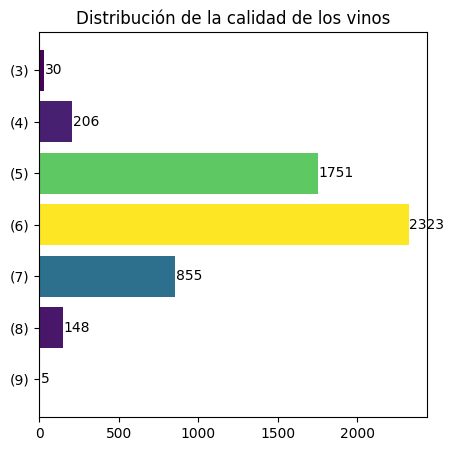

In [ ]:
counts = data['quality'].value_counts().sort_index()

# Gráfica del número de datos por calidad
fig, ax = plt.subplots(figsize=(5, 5))
norm = plt.Normalize(vmin=counts.min(), vmax=counts.max())
colors = cm.viridis(norm(counts))

bars = ax.barh(range(len(counts)), counts, color=colors)
ax.set_yticks(range(len(counts)))
ax.set_yticklabels([f"({n})" for n in counts.index])
for bar, count in zip(bars, counts):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
            str(count), va='center', fontsize=10)
plt.title("Distribución de la calidad de los vinos")
ax.invert_yaxis()
fig.show()

***
<span style="font-family:Cambria Math">

El gráfico revela un desbalance significativo en la distribución de los datos. Por ejemplo, mientras que hay solo 5 vinos con una calidad de **9**, la clase **6** cuenta con **2,323 registros**. Esto implica que la clase 9 representa apenas el **0.21%** de los datos de la clase 6.

Dado este desbalance, será necesario considerar estrategias como *over-sampling, under-sampling* o el uso de pesos ajustados para equilibrar las clases y mejorar el rendimiento del modelo.
</span>

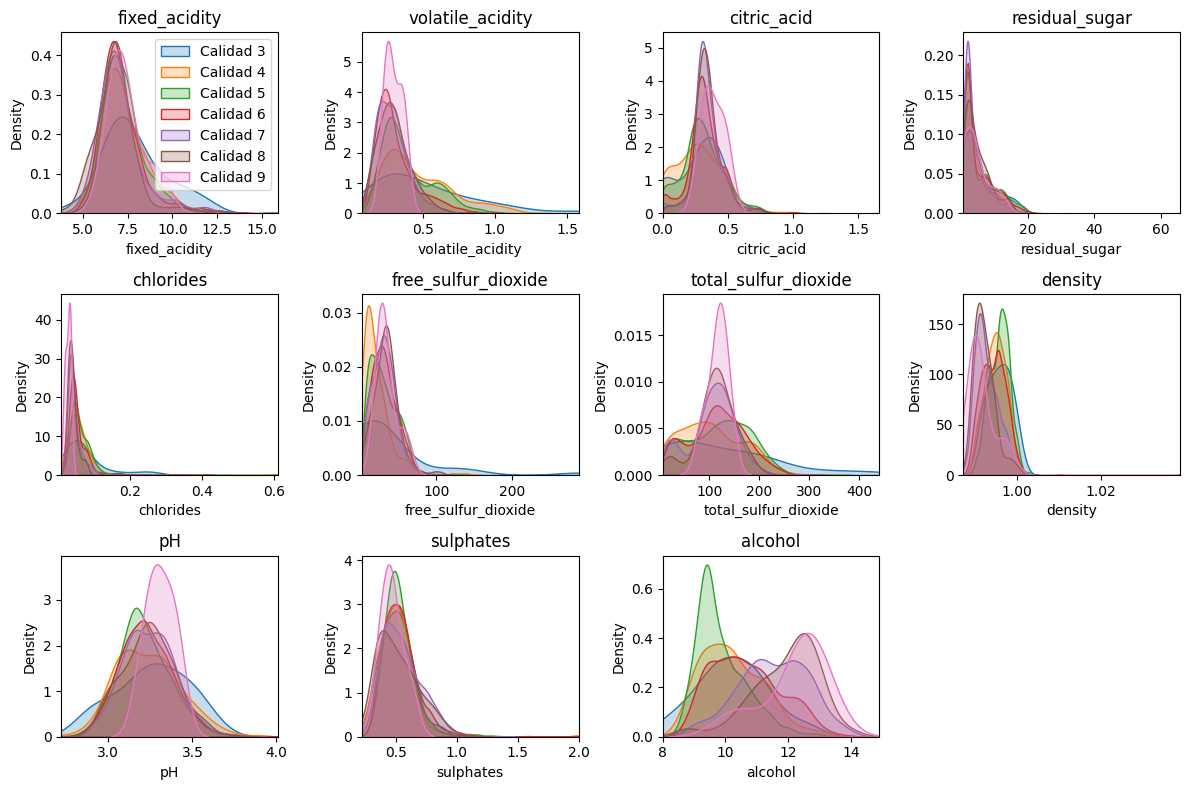

In [ ]:
features = data.columns[:-1]

# Plot de distribución por features y calidad
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    for indice in counts.index.tolist():
        #See usa kdeplott como alternativa de histplot
        sns.kdeplot(data=data[data['quality'] == indice][feature], label= 'Calidad '+ str(indice), fill=True)
    if i == 0:
        plt.legend()
    plt.title(feature)
    plt.xlim(data[feature].min(), data[feature].max())
plt.tight_layout()
plt.show()

***
<span style="font-family:Cambria Math">

A partir de esta gráfica, adaptada de uno de los talleres [³], se pueden identificar diferencias clave entre los vinos de alta y baja calidad:

- Los vinos de mayor calidad tienden a presentar valores bajos de **`volatile_acidity`** y **`chlorides`**.
- También muestran un **`total_sulfur_dioxide`** en un rango aproximado de **100 a 150**.
- Los vinos de menor calidad suelen tener valores más bajos de **`alcohol`**.
- El **`pH`** de los vinos de alta calidad se encuentra bien definido en el intervalo de **3.0 a 3.5**.

Estos hallazgos pueden ser útiles para comprender qué factores influyen en la calidad del vino y cómo pueden impactar en el modelo de clasificación.
</span>

***

<span style="font-family:Cambria Math">

## 3.2 *Pipeline* de Preprocesamiento

Se continúa con la construcción de los *pipelines* de preprocesamiento. A partir de este punto, algunos datos podrán ser transformados para optimizar la adecuación y el rendimiento de los modelos de clasificación. Por esta razón, el primer paso es separar adecuadamente los datos.

Para la división del conjunto de datos, se emplea el parámetro **`stratify`**, lo que permite mantener la proporción original de las clases en los subconjuntos de entrenamiento y prueba. Aunque la distribución de clases está desbalanceada, esta estrategia garantiza que la proporción se mantenga, lo que facilitará la aplicación posterior de técnicas de re-balanceo en el conjunto de entrenamiento.

El objetivo de este enfoque es asegurar que las transformaciones aplicadas sean similares en ambos conjuntos, reduciendo posibles sesgos en el modelo.
</span>

In [ ]:
#Separación de las variables

X = data.drop(columns='quality')
y = data['quality']

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, train_size=0.8, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((4254, 11), (1064, 11))

In [ ]:
y_train.shape, y_test.shape

((4254,), (1064,))

***

<span style="font-family:Cambria Math">

Durante la etapa de preprocesamiento, se definen los siguientes objetos para preparar los datos de manera óptima:

- Para abordar el desbalance de clases, se emplea **`SMOTE`** [⁴], una técnica de *oversampling* que genera muestras sintéticas en la clase minoritaria.
- Se aplica escalado con **`RobustScaler`**, ya que, como se observó previamente, varias variables contienen una gran cantidad de valores en las colas de su distribución. **`RobustScaler`** es ideal en estos casos, ya que reduce el impacto de los valores extremos.

Además, el número de muestras en la clase minoritaria es un fáctor clave para definir el parámetro **`k_neighbors`** en `SMOTE`. Un valor demasiado alto podría sobrepasar el número de datos originales en la clase minoritaria, afectando la calidad de las muestras sintéticas. En este conjunto de datos, el **mínimo valor viable** para **`k_neighbors`** es **3**.

Es fundamental aplicar estas transformaciones después de dividir los datos, de manera que el conjunto de prueba solo reciba las transformaciones sin ser utilizado en el ajuste (*fit*).

Cabe destacar que **`SMOTE`** no se aplicará a todos los modelos de clasificación. Algunos modelos permiten el uso de pesos ajustados para manejar el desbalance sin necesidad de *oversampling*. Por esta razón, se mantendrán dos versiones del conjunto de entrenamiento:  
- Una con `SMOTE` (*oversampling* aplicado).  
- Otra sin `SMOTE` (sin *oversampling*, para modelos con ajuste de pesos).
</span>

In [ ]:
# Deginición de objetos
smote = SMOTE(k_neighbors=3, random_state=RANDOM_STATE)
scaler = RobustScaler()

***

<span style="font-family:Cambria Math">

Adicionalmente, en la etapa de definición de objetos se define un `StratifiefKFold` que permitirá hacer un *cross-validation* estratificado en cada uno de los pipelines de búsqueda de hiperpárametros, más adelane.
</span>

In [ ]:
#Definición de objeto de cross-validación estratificada
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
#Transformación de datos con oversampling
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [ ]:
counts = y_train_over.value_counts()
print(counts)

quality
6    1858
5    1858
7    1858
3    1858
4    1858
8    1858
9    1858
Name: count, dtype: int64


***

<span style="font-family:Cambria Math">

En esta sección, se definen los diccionarios que se completarán más adelante con los resultados de los modelos de clasificación. Estos diccionarios permitirán resumir y comparar el desempeño de cada modelo. Se comienza con la creación del diccionario para almacenar los resultados de validación (idea tomada de los laboratorios de la clase) [⁵].

Es importante destacar que la métrica **`ROC-AUC`** presenta ciertas dificultades en su interpretación y cálculo en problemas multiclase, lo que la hace menos recomendable para este tipo de análisis.

Las métricas seleccionadas para evaluar los modelos incluyen:

- **`Accuracy`**: Proporción de predicciones correctas sobre el total de muestras.
- **`Recall`**: Capacidad del modelo para identificar correctamente las clases positivas.
- **`F1-score`**: Promedio armónico entre precisión y recall, útil en conjuntos de datos desbalanceados.

Estos resultados se presentarán en una tabla comparativa, junto con los tiempos de entrenamiento de cada modelo.
</span>

In [ ]:
#Diccionario de resultados de validación
dicc_resultados_val = {'modelo': [],
                      'Accuracy': [],
                      'Recall': [],
                      'F1-score': [],
                      'Tiempo de entrenamiento': [],
                      'Hiper-parámetros': []}

***

<span style="font-family:Cambria Math">

Se define una función que permitirá almacenar los datos de validación dentro del diccionario, junto con otra información relevante que facilitará la selección del modelo más adecuado.

Además, se implementa una función adicional para formatear el tiempo de procesamiento, garantizando que la información almacenada en el diccionario sea más clara y comprensible.
</span>

In [ ]:
# Dar formato al tiempo de procesamiento
def formatear_tiempo(segundos):
    if segundos < 60:
        return f"{segundos:.2f} s"
    else:
        minutos = int(segundos // 60)
        segundos_restantes = segundos % 60
        return f"{minutos} min {segundos_restantes:.2f} s"

In [ ]:
#Inclusión de datos a diccionario
def incluir_a_diccionario(results, nombre_modelo, tiempo_entrenamiento):
# Esta función espera una instancia de resultados de búsqueda de cross validation, por ejemplo: search.cv_results_
  candidato = np.flatnonzero(results['rank_test_accuracy'] == 1)[0]
  accuracy = results['mean_test_accuracy'][candidato]
  recall = results['mean_test_recall_weighted'][candidato]
  F1 = results['mean_test_f1_macro'][candidato]
  hiperparametros = results['params'][candidato]

  dicc_resultados_val['modelo'].append(nombre_modelo)
  dicc_resultados_val['Accuracy'].append(accuracy)
  dicc_resultados_val['Recall'].append(recall)
  dicc_resultados_val['F1-score'].append(F1)
  dicc_resultados_val['Tiempo de entrenamiento'].append(formatear_tiempo(tiempo_entrenamiento))
  dicc_resultados_val['Hiper-parámetros'].append(hiperparametros)
  display(pd.DataFrame(dicc_resultados_val))

***

<span style="font-family:Cambria Math">

De manera similar, se define un diccionario para almacenar las métricas de desempeño obtenidas durante la fase de *test*.

Es importante destacar que, dentro de las métricas, se emplea el **`recall` ponderado** (`average='weighted'`). Esta elección se debe a que, como se explicó anteriormente, no hay una razón específica para favorecer una clase sobre otra. Por lo tanto, se calcula un promedio ponderado de los *recalls* de todas las clases, asegurando una evaluación equilibrada del desempeño del modelo. Por otro lado, se prueba también *F1-Score* (para la versión multiclase), ya que su media harmónica puede darnos una mejor idea de cuán bien se está clasificando si favorecer una clase específica.
</span>

In [ ]:
#Diccionario de resultados test
dicc_resultados_test = {'modelo': [],
                        'Accuracy_Test': [],
                        'Recall_Test': [],
                      'F1-Score': [],
                      }

In [ ]:
#Inclusión de datos a diccionario test
def incluir_a_diccionario_test(modelo, nombre_modelo, X_test, y_test):
# Esta función espera una instancia de resultados de búsqueda de cross validation, por ejemplo: search.cv_results_
  accuracy = accuracy_score(y_test, modelo.predict(X_test))
  recall = recall_score(y_test, modelo.predict(X_test), average='weighted')
  y_pred = np.argmax(modelo.predict_proba(X_test), axis=1)
  f1_macro = f1_score(y_test, y_pred, average="macro")

  dicc_resultados_test['modelo'].append(nombre_modelo)
  dicc_resultados_test['Accuracy_Test'].append(accuracy)
  dicc_resultados_test['Recall_Test'].append(recall)
  dicc_resultados_test['F1-Score'].append(f1_macro)
  display(pd.DataFrame(dicc_resultados_test))

***

<span style="font-family:Cambria Math">

# 4. Entrenamiento de los Modelos y Búsqueda de Hiperparámetros

A continuación, se construyen las funciones necesarias para realizar la búsqueda de hiperparámetros en los modelos a evaluar. En este examen, se trabajará con los siguientes algoritmos:

- **`LogisticRegression`**
- **`MLPClassifier`**
- **`KNeighborsClassifier`**
- **`DecisionTreeClassifier`**
- **`RandomForestClassifier`**
- **`SVC`**
- **`XGBClassifier`**

Para optimizar la selección de hiperparámetros, se define un diccionario de modelos base, que servirá como punto de partida. En estos modelos iniciales, se mantiene el **random state** definido y se eligen configuraciones adecuadas para la convergencia y entrenamiento.

Por ejemplo, en el caso de **`MLPClassifier`**, se utiliza **`Adam`** como optimizador, ya que acelera la convergencia hacia un mínimo local de la función de error y reduce el riesgo de quedar atrapado en mínimos locales.

Como se explicó anteriormente, para los tres últimos modelos (**`SVC`**, **`RandomForestClassifier`** y **`XGBClassifier`**) se aplicará un **ajuste de pesos** para corregir el desbalance en las clases. Se definen dos enfoques para el ajuste de pesos:

1. **Pesos por clase** (`class_weight`), aplicados en modelos como `SVC` y `RandomForestClassifier`.
2. **Pesos basados en *samples*** (`sample_weight`), utilizados en `XGBClassifier` [⁶].

Estas estrategias permitirán mejorar la capacidad predictiva de los modelos en presencia de clases desbalanceadas sin necesidad de utilizar **`SMOTE`**.

</span>

In [ ]:
#Diccionario de pesos usado en RandomForest y SVC
clases, cuentas = np.unique(y_train, return_counts=True)
pesos = compute_class_weight(class_weight='balanced', classes=clases, y=y_train)
pesos_dict = dict(zip(clases, pesos))

#Sample weights usado para XGBoost
pesos = {clase: max(cuentas) / cuenta for clase, cuenta in zip(clases, cuentas)}
sample_weights = np.array([pesos[clase] for clase in y_train])

In [ ]:
# Diccionario de modelos base, en este mismo diccionario más adelante se guardaran los modelos óptimos de cada método
dicc_modelos = {'Regresión Logística': LogisticRegression(max_iter=500, random_state=RANDOM_STATE, solver='saga',n_jobs=-1),
                'Red Neuronal': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=RANDOM_STATE, solver='adam',activation='relu'),
                'K-Vecinos': KNeighborsClassifier(n_jobs=-1),
                'Árbol de Decisión': DecisionTreeClassifier(random_state=RANDOM_STATE),
                'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, criterion = 'gini'),
                'SVC': SVC(probability=True, random_state=RANDOM_STATE, kernel='poly',class_weight=pesos_dict),
                'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_STATE,sample_weight=sample_weights,use_label_encoder=False )}

***

<span style="font-family:Cambria Math">

Antes de la fase de entrenamiento, es fundamental escalar los conjuntos de entrenamiento y prueba para garantizar que los modelos trabajen con datos correctamente normalizados. Los primeros modelos serán entrenados con los conjuntos obtenidos tras aplicar *oversampling* al conjunto de entrenamiento.

> **Nota aclaratoria:**  
> La variable **`X_test_over`** no implica que se haya realizado *oversampling* en el conjunto de prueba, ya que esto sería incorrecto. En problemas de clasificación, el balanceo de clases solo debe aplicarse al conjunto de entrenamiento.  
>  
> La denominación **"over"** en `X_test_over` se debe a que el escalado aplicado a este conjunto se realizó con los parámetros ajustados sobre `X_train_over`, asegurando coherencia en la transformación de los datos.

</span>

In [ ]:
#Escalamiento de los datos entrenamiento y test
X_train_over = scaler.fit_transform(X_train_over)
#X_test escalado a la medida de X_train_over
X_test_over = scaler.transform(X_test)

***
<span style="font-family:Cambria Math">

## 4.1 Modelo: Regresión Logística

La búsqueda de hiperparámetros se realizará de manera similar para todos los modelos. Se empleará una distribución de búsqueda en lugar de una grilla fija, utilizando la función **`RandomizedSearchCV`**. Posteriormente, se procederá con el entrenamiento del modelo y la inclusión de los resultados de validación y prueba.

En el caso de la Regresión Logística [⁷], se optimizarán los siguientes hiperparámetros: **`C`** (fuerza de regularización inversa)  y  Tipo de regularización (`penalty`).

Dado que en este caso se enfrenta un problema de clasificación multiclase, se utilizará el enfoque **"one-vs-rest" (OvR)**, dependiendo de la implementación del clasificador.
</span>

In [ ]:
#Búsqueda aleatoria para el modelo de regresión logístca
def modelo_LogReg(X_train, X_test, y_train, y_test):
  nombre = 'Regresión Logística'
  # Definición de grilla de parámetros
  param_dist = {'C': uniform(0.1, 10),
                 'penalty': ['l1', 'l2']}
  #Toma modelo base del diccionario de modelos
  log_reg = dicc_modelos[nombre]
  #Nuevamente se toma recall ponderado
  scores = ['accuracy', 'recall_weighted','f1_macro']
  #Definición del RandomizedSearch
  random_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_dist, n_iter=20, scoring= scores, cv=kfold ,refit='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
  #Entrenamiento y toma de tiempos
  start_time = time.time()
  random_search.fit(X_train, y_train)
  time_modelo = time.time() - start_time
  # Inclusión de diccionarios
  incluir_a_diccionario(random_search.cv_results_, nombre, time_modelo)
  incluir_a_diccionario_test(random_search.best_estimator_,nombre, X_test, y_test)
  dicc_modelos[nombre] = random_search.best_estimator_
  df_modelos = pd.DataFrame.from_dict(dicc_modelos, orient='index')
  display(df_modelos)
  return random_search

In [ ]:
random_logreg = modelo_LogReg(X_train_over, X_test_over, y_train_over, y_test)

,modelo,Accuracy,Recall,F1-score,Tiempo de entrenamiento,Hiper-parámetros
0,Regresión Logística,0.503228,0.503228,0.496427,10 min 45.29 s,"{'C': 4.815922800664158, 'penalty': 'l1'}"


,modelo,Accuracy_Test,Recall_Test,F1-Score
0,Regresión Logística,0.305451,0.305451,0.008163


,0
Regresión Logística,"LogisticRegression(C=4.815922800664158, max_it..."
Red Neuronal,"MLPClassifier(hidden_layer_sizes=(50,), max_it..."
K-Vecinos,KNeighborsClassifier(n_jobs=-1)
Árbol de Decisión,DecisionTreeClassifier(random_state=13)
Random Forest,RandomForestClassifier(random_state=13)
SVC,"SVC(class_weight={3: 25.321428571428573, 4: 3...."
XGBoost,"XGBClassifier(base_score=None, booster=None, c..."


***
<span style="font-family:Cambria Math">

## 4.2 Modelo: Perceptrón Multicapa

Para este modelo, la búsqueda de hiperparámetros se realiza teniendo en cuenta que ña capa de entrada consta de 11 *features*, mientras que la capa de salida tiene 10 neuronas, correspondientes a las 10 clases del problema de clasificación. Es importante, anotar que en todos los modelos debemos abordar el problema como si tuvieramos 10 clases a pesar de que en el conjunto de dato no haya algunos niveles de calidad. Eso es porque la solución debe ser generalizable y en otro conjunto de datos pueden haber los niveles de calidad que no encontramos acá.
</span>

In [ ]:
#Búsqueda aleatoria para el modelo de MLP
def modelo_MLP(X_train, X_test, y_train, y_test):
  nombre = 'Red Neuronal'
  #Definición de grilla de parámetros
  #Se define el espacio de búsqueda de las capas ocultas en un rango razonable entre el rango de entrada y de salida
  param_dist = {'hidden_layer_sizes': [(11,), (33,), (22, 10), (33, 22, 10)],
                'alpha': [0.0001, 0.001, 0.01]
                }
  #Toma modelo base del diccionario de modelos
  modelo_MLP = dicc_modelos[nombre]
  #Nuevamente se toma recall ponderado
  scores = ['accuracy','recall_weighted','f1_macro']
  #Definición del RandomizedSearch
  random_search = RandomizedSearchCV(estimator= modelo_MLP, param_distributions=param_dist, n_iter=20, scoring= scores, cv=kfold ,refit='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
  #Entrenamiento y toma de tiempos
  start_time = time.time()
  random_search.fit(X_train, y_train)
  time_modelo = time.time() - start_time
  # Inclusión de diccionarios
  incluir_a_diccionario(random_search.cv_results_, nombre, time_modelo)
  incluir_a_diccionario_test(random_search.best_estimator_,nombre, X_test, y_test)
  dicc_modelos[nombre] = random_search.best_estimator_
  df_modelos = pd.DataFrame.from_dict(dicc_modelos, orient='index')
  display(df_modelos)
  return random_search

In [ ]:
random_MLP = modelo_MLP(X_train_over, X_test_over, y_train_over, y_test)

,modelo,Accuracy,Recall,F1-score,Tiempo de entrenamiento,Hiper-parámetros
0,Regresión Logística,0.503228,0.503228,0.496427,10 min 45.29 s,"{'C': 4.815922800664158, 'penalty': 'l1'}"
1,Red Neuronal,0.758265,0.758265,0.749747,15 min 8.73 s,"{'hidden_layer_sizes': (33, 22, 10), 'alpha': ..."


,modelo,Accuracy_Test,Recall_Test,F1-Score
0,Regresión Logística,0.305451,0.305451,0.008163
1,Red Neuronal,0.416353,0.416353,0.004665


,0
Regresión Logística,"LogisticRegression(C=4.815922800664158, max_it..."
Red Neuronal,"MLPClassifier(hidden_layer_sizes=(33, 22, 10),..."
K-Vecinos,KNeighborsClassifier(n_jobs=-1)
Árbol de Decisión,DecisionTreeClassifier(random_state=13)
Random Forest,RandomForestClassifier(random_state=13)
SVC,"SVC(class_weight={3: 25.321428571428573, 4: 3...."
XGBoost,"XGBClassifier(base_score=None, booster=None, c..."


***
<span style="font-family:Cambria Math">

## 4.3 Modelo: K-Vecinos


Para el modelo **K-Vecinos (KNN)** se optimizarán los siguientes hiperparámetro  **`n_neighbors`** (Número de vecinos) y **`metric`** (Métrica de distancia)
</span>

In [ ]:
# Búsqueda aleatoria para el modelo de KNN
def modelo_KNN(X_train, X_test, y_train, y_test):
  nombre = 'K-Vecinos'
  #Definición de grilla de parámetros
  param_dist = {'n_neighbors': list(range(1, 20)),
                'metric': ['euclidean', 'manhattan'],
               }
  #Toma modelo base del diccionario de modelos
  modelo_KNN = dicc_modelos[nombre]
  #Nuevamente se toma recall ponderado
  scores = ['accuracy','recall_weighted','f1_macro']
  #Definición del RandomizedSearch
  random_search = RandomizedSearchCV(estimator= modelo_KNN, param_distributions=param_dist, n_iter=20, scoring= scores, cv=kfold ,refit='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
  #Entrenamiento y toma de tiempos
  start_time = time.time()
  random_search.fit(X_train, y_train)
  time_modelo = time.time() - start_time
  # Inclusión de diccionarios
  incluir_a_diccionario(random_search.cv_results_, nombre, time_modelo)
  incluir_a_diccionario_test(random_search.best_estimator_,nombre, X_test, y_test)
  dicc_modelos[nombre] = random_search.best_estimator_
  df_modelos = pd.DataFrame.from_dict(dicc_modelos, orient='index')
  display(df_modelos)
  return random_search

In [ ]:
random_KNN = modelo_KNN(X_train_over, X_test_over, y_train_over, y_test)

,modelo,Accuracy,Recall,F1-score,Tiempo de entrenamiento,Hiper-parámetros
0,Regresión Logística,0.503228,0.503228,0.496427,10 min 45.29 s,"{'C': 4.815922800664158, 'penalty': 'l1'}"
1,Red Neuronal,0.758265,0.758265,0.749747,15 min 8.73 s,"{'hidden_layer_sizes': (33, 22, 10), 'alpha': ..."
2,K-Vecinos,0.841996,0.841996,0.831457,36.46 s,"{'n_neighbors': 1, 'metric': 'manhattan'}"


,modelo,Accuracy_Test,Recall_Test,F1-Score
0,Regresión Logística,0.305451,0.305451,0.008163
1,Red Neuronal,0.416353,0.416353,0.004665
2,K-Vecinos,0.458647,0.458647,0.005131


,0
Regresión Logística,"LogisticRegression(C=4.815922800664158, max_it..."
Red Neuronal,"MLPClassifier(hidden_layer_sizes=(33, 22, 10),..."
K-Vecinos,"KNeighborsClassifier(metric='manhattan', n_job..."
Árbol de Decisión,DecisionTreeClassifier(random_state=13)
Random Forest,RandomForestClassifier(random_state=13)
SVC,"SVC(class_weight={3: 25.321428571428573, 4: 3...."
XGBoost,"XGBClassifier(base_score=None, booster=None, c..."


***
<span style="font-family:Cambria Math">



## 4.4 Modelo: Árbol de Decisión

Se optimizarán los siguientes hiperparámetros:

- **`criterion`** (Criterio de división):  
  - **`gini`**: Mide la impureza, favoreciendo divisiones con clases más puras.  
  - **`entropy`**: Usa la ganancia de información, priorizando divisiones con mayor reducción de incertidumbre.  

- **`max_depth`** (Profundidad máxima):  
  - Valores bajos:Modelo más simple (*underfitting*).  
  - Valores altos: Mayor riesgo de *overfitting*.  

</span>

In [ ]:
#Búsqueda aleatoria para el modelo de árbol de decisión
def modelo_tree(X_train, X_test, y_train, y_test):
  nombre = 'Árbol de Decisión'
  #Definición de grilla de parámetros
  param_dist = {
      'criterion': ['gini', 'entropy'],
      'max_depth': list(range(3, 21)),
  }
  #Toma modelo base del diccionario de modelos
  modelo_tree = dicc_modelos[nombre]
  #Nuevamente se toma recall ponderado
  scores = ['accuracy', 'recall_weighted','f1_macro']
  #Definición del RandomizedSearch
  random_search = RandomizedSearchCV(estimator= modelo_tree, param_distributions=param_dist, n_iter=20, scoring= scores, cv=kfold ,refit='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
  #Entrenamiento y toma de tiempos
  start_time = time.time()
  random_search.fit(X_train, y_train)
  time_modelo = time.time() - start_time
  # Inclusión de diccionarios
  incluir_a_diccionario(random_search.cv_results_, nombre, time_modelo)
  incluir_a_diccionario_test(random_search.best_estimator_,nombre, X_test, y_test)
  dicc_modelos[nombre] = random_search.best_estimator_
  df_modelos = pd.DataFrame.from_dict(dicc_modelos, orient='index')
  display(df_modelos)
  return random_search

In [ ]:
random_tree = modelo_tree(X_train_over, X_test_over, y_train_over, y_test)

,modelo,Accuracy,Recall,F1-score,Tiempo de entrenamiento,Hiper-parámetros
0,Regresión Logística,0.503228,0.503228,0.496427,10 min 45.29 s,"{'C': 4.815922800664158, 'penalty': 'l1'}"
1,Red Neuronal,0.758265,0.758265,0.749747,15 min 8.73 s,"{'hidden_layer_sizes': (33, 22, 10), 'alpha': ..."
2,K-Vecinos,0.841996,0.841996,0.831457,36.46 s,"{'n_neighbors': 1, 'metric': 'manhattan'}"
3,Árbol de Decisión,0.752653,0.752653,0.745605,17.92 s,"{'max_depth': 17, 'criterion': 'entropy'}"


,modelo,Accuracy_Test,Recall_Test,F1-Score
0,Regresión Logística,0.305451,0.305451,0.008163
1,Red Neuronal,0.416353,0.416353,0.004665
2,K-Vecinos,0.458647,0.458647,0.005131
3,Árbol de Decisión,0.420113,0.420113,0.007524


,0
Regresión Logística,"LogisticRegression(C=4.815922800664158, max_it..."
Red Neuronal,"MLPClassifier(hidden_layer_sizes=(33, 22, 10),..."
K-Vecinos,"KNeighborsClassifier(metric='manhattan', n_job..."
Árbol de Decisión,"DecisionTreeClassifier(criterion='entropy', ma..."
Random Forest,RandomForestClassifier(random_state=13)
SVC,"SVC(class_weight={3: 25.321428571428573, 4: 3...."
XGBoost,"XGBClassifier(base_score=None, booster=None, c..."


***
<span style="font-family:Cambria Math">

## 4.5 Modelo: Random Forest

Para el modelo Random Forest se optimizarán los siguientes hiperparámetros **`n_estimators`** (Número de árboles) y **`max_depth`** (Profundidad máxima de cada árbol).

Random Forest debería reducir el problema de varianza de los árboles individuales, pero el aumento de `n_estimators` debería incrementar el tiempo de entrenamiento.

También es importante anotar que a partir de aquí comienzan los modelos que pueden controlar por sí mismos el problema de desbalanceo en las clases. Razón por la cual, entrenamos con los conjuntos de datos sin hacer *oversampling*.
</span>

In [ ]:
# Hacemos fit y escalamiento con el conjunto de datos de entrenamiento original (sin SMOTE)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Búsqueda aleatoria para el modelo de Random Forest
def modelo_RF(X_train, X_test, y_train, y_test):
  nombre = 'Random Forest'
  #Definición de grilla de parámetros
  param_dist = { 'n_estimators': randint(100, 500),
                'max_depth': list(range(5, 50, 5)),
  }
  #Toma modelo base del diccionario de modelos
  modelo_RF = dicc_modelos[nombre]
  #Nuevamente se toma recall ponderado
  scores = ['accuracy','recall_weighted','f1_macro']
  #Definición del RandomizedSearch
  random_search = RandomizedSearchCV(estimator= modelo_RF, param_distributions=param_dist, n_iter=20, scoring= scores, cv=kfold ,refit='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
  #Entrenamiento y toma de tiempos
  start_time = time.time()
  random_search.fit(X_train, y_train)
  time_modelo = time.time() - start_time
  # Inclusión de diccionarios
  incluir_a_diccionario(random_search.cv_results_, nombre, time_modelo)
  incluir_a_diccionario_test(random_search.best_estimator_,nombre, X_test, y_test)
  dicc_modelos[nombre] = random_search.best_estimator_
  df_modelos = pd.DataFrame.from_dict(dicc_modelos, orient='index')
  display(df_modelos)
  return random_search

In [ ]:
random_RF = modelo_RF(X_train, X_test, y_train, y_test)

,modelo,Accuracy,Recall,F1-score,Tiempo de entrenamiento,Hiper-parámetros
0,Regresión Logística,0.503228,0.503228,0.496427,10 min 45.29 s,"{'C': 4.815922800664158, 'penalty': 'l1'}"
1,Red Neuronal,0.758265,0.758265,0.749747,15 min 8.73 s,"{'hidden_layer_sizes': (33, 22, 10), 'alpha': ..."
2,K-Vecinos,0.841996,0.841996,0.831457,36.46 s,"{'n_neighbors': 1, 'metric': 'manhattan'}"
3,Árbol de Decisión,0.752653,0.752653,0.745605,17.92 s,"{'max_depth': 17, 'criterion': 'entropy'}"
4,Random Forest,0.562529,0.562529,0.255649,3 min 58.46 s,"{'max_depth': 15, 'n_estimators': 276}"


,modelo,Accuracy_Test,Recall_Test,F1-Score
0,Regresión Logística,0.305451,0.305451,0.008163
1,Red Neuronal,0.416353,0.416353,0.004665
2,K-Vecinos,0.458647,0.458647,0.005131
3,Árbol de Decisión,0.420113,0.420113,0.007524
4,Random Forest,0.569549,0.569549,0.002154


,0
Regresión Logística,"LogisticRegression(C=4.815922800664158, max_it..."
Red Neuronal,"MLPClassifier(hidden_layer_sizes=(33, 22, 10),..."
K-Vecinos,"KNeighborsClassifier(metric='manhattan', n_job..."
Árbol de Decisión,"DecisionTreeClassifier(criterion='entropy', ma..."
Random Forest,"(DecisionTreeClassifier(max_depth=15, max_feat..."
SVC,"SVC(class_weight={3: 25.321428571428573, 4: 3...."
XGBoost,"XGBClassifier(base_score=None, booster=None, c..."


***
<span style="font-family:Cambria Math">

## 4.6 Modelo: Máquinas de Vectores de Soporte

El modelo SVC (la versión lineal de SVM) busca maximizaR el margen entre los datos. Para este modelo se optimizarán los hiperparámetros**`C`** (parámetro de regularización) y  **`degree`** (Grado del polinomio en el kernel *poly*)

SVC funciona bien en espacios de alta dimensión, pero puede ser costoso computacionalmente con grandes volúmenes de datos.
</span>

In [ ]:
#Búsqueda aleatoria para el modelo de SVC
def modelo_SVC(X_train, X_test, y_train, y_test):
  nombre = 'SVC'
  #Definición de grilla de parámetros
  param_dist = {'C': np.logspace(-3, 3, 10),
                'degree': [2, 3, 4, 5]}
  #Toma modelo base del diccionario de modelos
  modelo_SVC = dicc_modelos[nombre]
  #Nuevamente se toma recall ponderado
  scores = ['accuracy', 'recall_weighted','f1_macro']
  #Definición del RandomizedSearch
  random_search = RandomizedSearchCV(estimator= modelo_SVC, param_distributions=param_dist, n_iter=20, scoring= scores, cv=kfold ,refit='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
  #Entrenamiento y toma de tiempos
  start_time = time.time()
  random_search.fit(X_train, y_train)
  time_modelo = time.time() - start_time
  # Inclusión de diccionarios
  incluir_a_diccionario(random_search.cv_results_, nombre, time_modelo)
  incluir_a_diccionario_test(random_search.best_estimator_,nombre, X_test, y_test)
  dicc_modelos[nombre] = random_search.best_estimator_
  df_modelos = pd.DataFrame.from_dict(dicc_modelos, orient='index')
  display(df_modelos)
  return random_search

In [ ]:
random_SVC = modelo_SVC(X_train, X_test, y_train, y_test)

,modelo,Accuracy,Recall,F1-score,Tiempo de entrenamiento,Hiper-parámetros
0,Regresión Logística,0.503228,0.503228,0.496427,10 min 45.29 s,"{'C': 4.815922800664158, 'penalty': 'l1'}"
1,Red Neuronal,0.758265,0.758265,0.749747,15 min 8.73 s,"{'hidden_layer_sizes': (33, 22, 10), 'alpha': ..."
2,K-Vecinos,0.841996,0.841996,0.831457,36.46 s,"{'n_neighbors': 1, 'metric': 'manhattan'}"
3,Árbol de Decisión,0.752653,0.752653,0.745605,17.92 s,"{'max_depth': 17, 'criterion': 'entropy'}"
4,Random Forest,0.562529,0.562529,0.255649,3 min 58.46 s,"{'max_depth': 15, 'n_estimators': 276}"
5,SVC,0.470618,0.470618,0.260441,48 min 40.12 s,"{'degree': 4, 'C': 46.41588833612773}"


,modelo,Accuracy_Test,Recall_Test,F1-Score
0,Regresión Logística,0.305451,0.305451,0.008163
1,Red Neuronal,0.416353,0.416353,0.004665
2,K-Vecinos,0.458647,0.458647,0.005131
3,Árbol de Decisión,0.420113,0.420113,0.007524
4,Random Forest,0.569549,0.569549,0.002154
5,SVC,0.448308,0.448308,0.001016


,0
Regresión Logística,"LogisticRegression(C=4.815922800664158, max_it..."
Red Neuronal,"MLPClassifier(hidden_layer_sizes=(33, 22, 10),..."
K-Vecinos,"KNeighborsClassifier(metric='manhattan', n_job..."
Árbol de Decisión,"DecisionTreeClassifier(criterion='entropy', ma..."
Random Forest,"(DecisionTreeClassifier(max_depth=15, max_feat..."
SVC,"SVC(C=46.41588833612773,\n class_weight={3:..."
XGBoost,"XGBClassifier(base_score=None, booster=None, c..."


***
<span style="font-family:Cambria Math">

## 4.7 Modelo: XGBoost

XGBoost es un algoritmo de *boosting* basado en árboles de decisión que optimiza el aprendizaje secuencial mediante la corrección de errores de predicciones previas. Además, maneja muy bien el desbalance de clases mediante el re-pesado de los *samples* (`scale_pos_weight`).

`XGBClassifier` asume que las clases inician en 0 y siguen un orden creciente. Si los valores en el conjunto de datos no son consecutivos (por ejemplo, en este caso, las clases son `[3, 4, 5, 6, 7, 8, 9]`), se requiere un *encoder* para transformarlas a `[0, 1, 2, 3, 4, 5, 6]` y garantizar que el modelo funcione correctamente.

Es importante destacar que XGBoost es altamente robusto frente a *overfitting*. Su capacidad para manejar datos desbalanceados y su optimización de la construcción de árboles lo convierten en una opción muy buena para este problema en particular.
</span>

In [ ]:
#Transformación de XGBClassifier para que pueda entender las etiquetas de clasficación
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

In [ ]:
#Búsqueda aleatoria para el modelo de XGBoost
def modelo_XGB(X_train, X_test, y_train, y_test):
  nombre = 'XGBoost'
  #Definición de grilla de parámetros
  param_dist = {'n_estimators': np.arange(50, 500, 50),
                'max_depth': np.arange(3, 12, 2)}
  #Toma modelo base del diccionario de modelos
  modelo_XGB = dicc_modelos[nombre]
  #Nuevamente se toma recall ponderado
  scores = ['accuracy', 'recall_weighted','f1_macro']
  #Definición del RandomizedSearch
  random_search = RandomizedSearchCV(estimator= modelo_XGB, param_distributions=param_dist, n_iter=20, scoring= scores, cv=kfold ,refit='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
  #Entrenamiento y toma de tiempos
  start_time = time.time()
  random_search.fit(X_train, y_train)
  time_modelo = time.time() - start_time
  # Inclusión de diccionarios
  incluir_a_diccionario(random_search.cv_results_, nombre, time_modelo)
  incluir_a_diccionario_test(random_search.best_estimator_,nombre, X_test, y_test)
  dicc_modelos[nombre] = random_search.best_estimator_
  df_modelos = pd.DataFrame.from_dict(dicc_modelos, orient='index')
  display(df_modelos)
  return random_search

In [ ]:
random_XGB = modelo_XGB(X_train, X_test, y_train_enc, y_test_enc)

,modelo,Accuracy,Recall,F1-score,Tiempo de entrenamiento,Hiper-parámetros
0,Regresión Logística,0.503228,0.503228,0.496427,10 min 45.29 s,"{'C': 4.815922800664158, 'penalty': 'l1'}"
1,Red Neuronal,0.758265,0.758265,0.749747,15 min 8.73 s,"{'hidden_layer_sizes': (33, 22, 10), 'alpha': ..."
2,K-Vecinos,0.841996,0.841996,0.831457,36.46 s,"{'n_neighbors': 1, 'metric': 'manhattan'}"
3,Árbol de Decisión,0.752653,0.752653,0.745605,17.92 s,"{'max_depth': 17, 'criterion': 'entropy'}"
4,Random Forest,0.562529,0.562529,0.255649,3 min 58.46 s,"{'max_depth': 15, 'n_estimators': 276}"
5,SVC,0.470618,0.470618,0.260441,48 min 40.12 s,"{'degree': 4, 'C': 46.41588833612773}"
6,XGBoost,0.548424,0.548424,0.273139,3 min 1.58 s,"{'n_estimators': 150, 'max_depth': 9}"


,modelo,Accuracy_Test,Recall_Test,F1-Score
0,Regresión Logística,0.305451,0.305451,0.008163
1,Red Neuronal,0.416353,0.416353,0.004665
2,K-Vecinos,0.458647,0.458647,0.005131
3,Árbol de Decisión,0.420113,0.420113,0.007524
4,Random Forest,0.569549,0.569549,0.002154
5,SVC,0.448308,0.448308,0.001016
6,XGBoost,0.550752,0.550752,0.298937


,0
Regresión Logística,"LogisticRegression(C=4.815922800664158, max_it..."
Red Neuronal,"MLPClassifier(hidden_layer_sizes=(33, 22, 10),..."
K-Vecinos,"KNeighborsClassifier(metric='manhattan', n_job..."
Árbol de Decisión,"DecisionTreeClassifier(criterion='entropy', ma..."
Random Forest,"(DecisionTreeClassifier(max_depth=15, max_feat..."
SVC,"SVC(C=46.41588833612773,\n class_weight={3:..."
XGBoost,"XGBClassifier(base_score=None, booster=None, c..."


***
<span style="font-family:Cambria Math">

# 5. Evaluación del modelo: Comparación de rendimiento

Tras el entrenamiento de los modelos y la búsqueda de hiperparámetros con **`RandomizedSearchCV`**, es fundamental visualizar y comparar las métricas de rendimiento.

Para ello, se presentan dos gráficos utilizados en clase:

1. Visualización en 3D de dos hiperparámetros en relación con el **`accuracy`** [⁸].  
2. Matriz de confusión en formato *heatmap*, adaptada para clasificación multiclase [⁹].

Es importante considerar que algunos hiperparámetros optimizados son categóricos. Aunque la primera visualización es en "3D", se puede ajustar las variables para que sean numéricas y así poder visualizarlas.
</span>

In [ ]:
# Visualización de resultados en dos gráficas, esta función acepta un objeto obtenido por RandomizedSearchCV entrenado con cualquier modelo
def plot_resultados(random_search, X_test, y_test, nombre_modelo: str, XGBoost = False):

    # Los resultados vienen en formato JSON se ajustan para poder tomar los hiperpámetros de manera fácil
    hiperparametros = pd.json_normalize(random_search.cv_results_['params'])
    accuracy_scores = random_search.cv_results_['mean_test_accuracy']

    # Algunos hipeparámetros pueden llegar a ser categóricas en orden de verla en un plot 3D se ajusta
    categorias = {}
    for col in hiperparametros.select_dtypes(include=['object']).columns:
        hiperparametros[col] = hiperparametros[col].apply(str)
        hiperparametros[col], categorias[col] = hiperparametros[col].astype('category').factorize()

    nombres_hiperparametros = list(hiperparametros.columns[:2])
    hiperparametro_1 = hiperparametros.iloc[:, 0]
    hiperparametro_2 = hiperparametros.iloc[:, 1]

    fig = plt.figure(figsize=(12, 5))

    # Gráfico 3D de hiperparámetros vs Accuracy
    ax1 = fig.add_subplot(121, projection='3d')
    scatter = ax1.scatter(hiperparametro_1, hiperparametro_2, accuracy_scores, c=accuracy_scores, cmap='viridis')

    ax1.set_xlabel(nombres_hiperparametros[0])
    ax1.set_ylabel(nombres_hiperparametros[1])
    ax1.set_title('Hiperparámetros vs Accuracy')
    ax1.set_zlabel('Accuracy')

    # Reemplazar números por etiquetas en el eje Y si es categórico
    if nombres_hiperparametros[1] in categorias:
        ax1.set_yticks(range(len(categorias[nombres_hiperparametros[1]])))
        ax1.set_yticklabels(categorias[nombres_hiperparametros[1]])

    #Si el modelo que se está graficando es XGBoost invierte transformación
    if XGBoost:
      y_pred_encoded = random_search.predict(X_test)
      y_pred = encoder.inverse_transform(y_pred_encoded)
      y_test = encoder.inverse_transform(y_test)
    else:
      y_pred = random_search.best_estimator_.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(1, 11))
    etiquetas = ["Clase " + str(c) for c in np.arange(1, 11)]

    cm_df = pd.DataFrame(cm, index=etiquetas, columns=etiquetas)

    # Gráfico de la matriz de confusió
    ax2 = fig.add_subplot(122)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g', ax=ax2)
    ax2.set_title("Matriz de Confusión")
    ax2.set_xlabel("Predicciones")
    ax2.set_ylabel("Datos Reales")
    fig.suptitle("Gráficas de rendimiento de "+ nombre_modelo, fontsize=16)

    plt.tight_layout()
    plt.show()

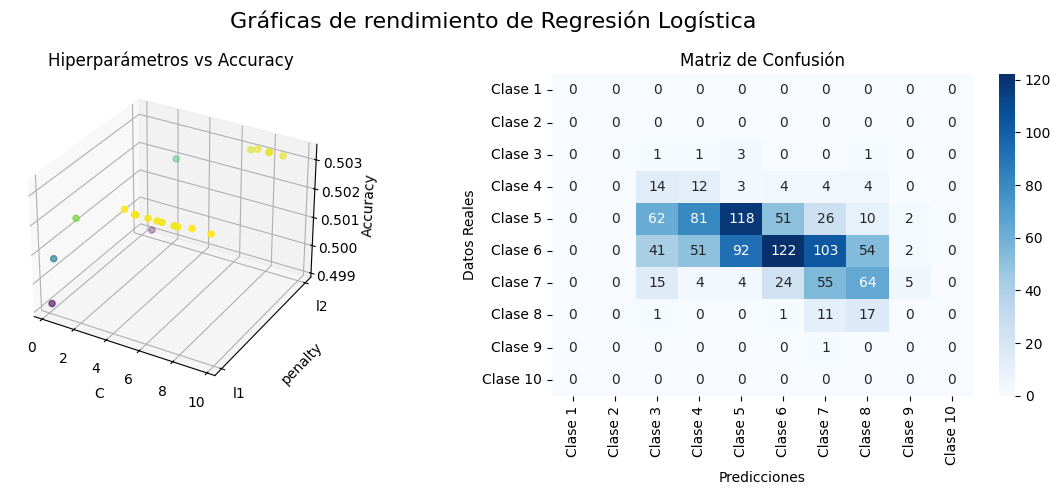

In [ ]:
plot_resultados(random_logreg, X_test_over, y_test, nombre_modelo = 'Regresión Logística')

***
<span style="font-family:Cambria Math">

En la primera visualización, se observa que la **`accuracy`** tiende a estabilizarse cerca del **50%**, lo que indica una dificultad en la clasificación. En la matriz de confusión, se destaca que las clases intermedias (5, 6 y 7) presentan mayor cantidad de datos y errores de clasificación, mientras que las clases extremas tienen una representación más baja.

Es importante analizar no solo la **`accuracy`**, sino también cómo se distribuyen los errores, ya que equivocarse entre clases similares es menos crítico que hacerlo entre clases diametralmente opuestas.
</span>

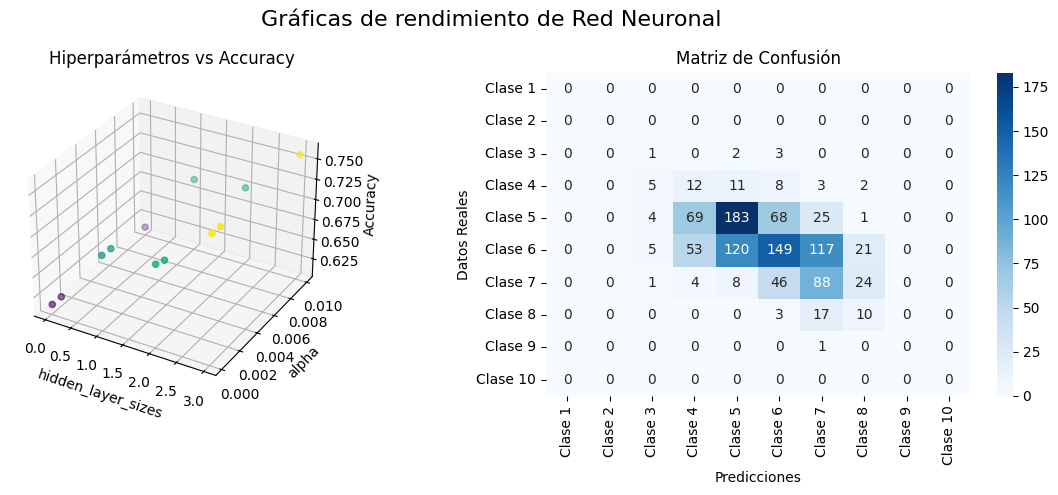

In [ ]:
plot_resultados(random_MLP, X_test_over, y_test,nombre_modelo = 'Red Neuronal')

***
<span style="font-family:Cambria Math">

El modelo de Perceptrón Multicapa (MLP) muestra una mejor **accuracy** a medida que aumentamos el número de capas y la complejidad del modelo. Sin embargo, es fundamental evitar un incremento excesivo para prevenir el *overfitting*.

Además, la matriz de confusión indica una menor dispersión en las predicciones, especialmente en las clases 5, 6 y 7, que ahora se confunden menos con las clases extremas. Esto contrasta con la Regresión Logística, donde la confusión entre clases distantes era más evidente.

</span>

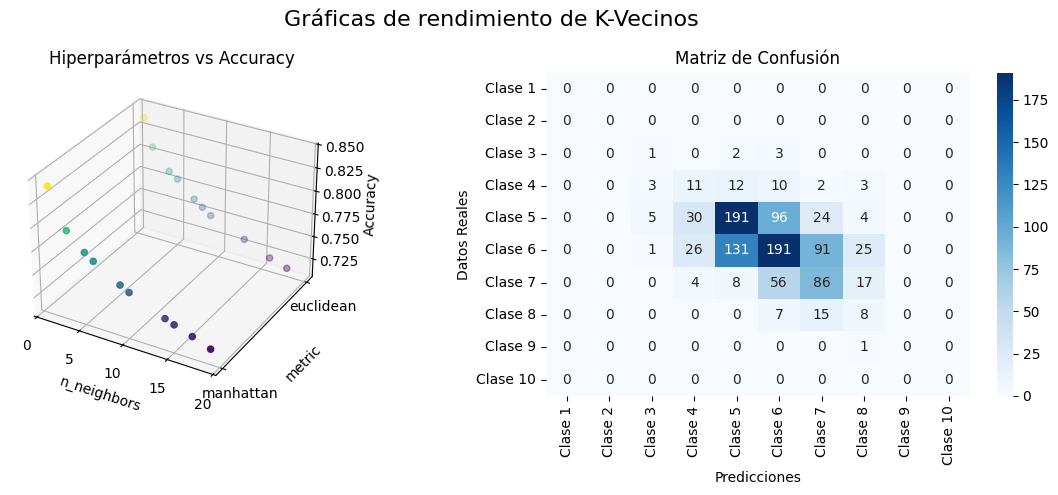

In [ ]:
plot_resultados(random_KNN, X_test_over, y_test,nombre_modelo = 'K-Vecinos')


***
<span style="font-family:Cambria Math">

En la gráfica de hiperparámetros, se observa una convergencia armoniosa, pero con una advertencia importante: el número de vecinos que genera un mayor **`accuracy`** (recordemos que este **`accuracy`** se obtuvo mediante *cross-validation*) es el más pequeño, lo que puede indicar **overfitting**.

En el modelo de K-Vecinos, se notan algunas mejoras, especialmente en las clases 5 y 6, que muestran una clasificación porcentualmente más precisa. Además, el único elemento de la clase 9 está más cerca de ser clasificado correctamente, aunque se asignó a la clase 8. Sin embargo, la clase 4 continúa siendo mal clasificada, como en los modelos anteriores.

</span>

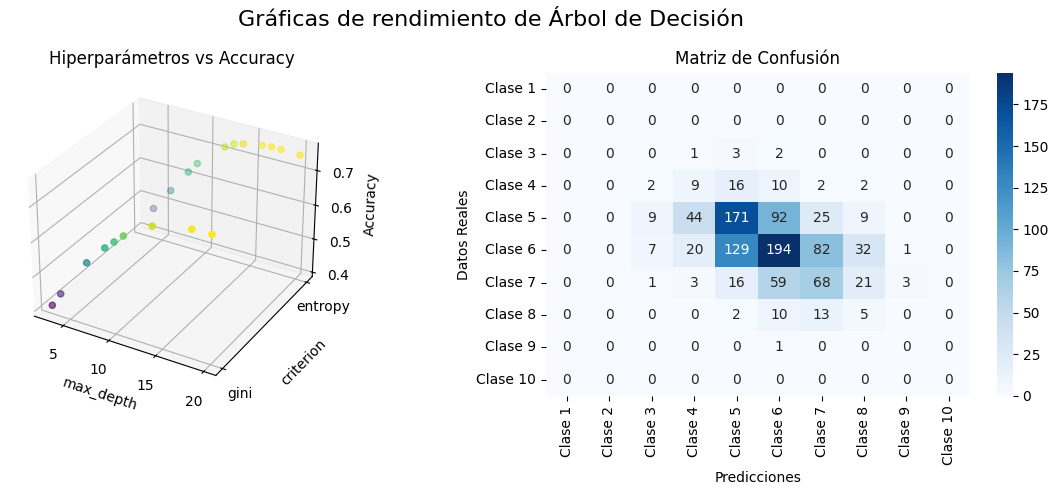

In [ ]:
plot_resultados(random_tree, X_test_over, y_test, nombre_modelo = 'Árbol de Decisión')

***
<span style="font-family:Cambria Math">

El algoritmo de Árbol de Decisión muestra resultados similares al modelo anterior, pero con una mayor desviación en la clasificación de la clase 9. Hasta el momento, las clases con los peores resultados de clasificación son la 3, 4, 8 y 9, lo que podría estar influenciado por el número de datos en el conjunto *test*.

</span>

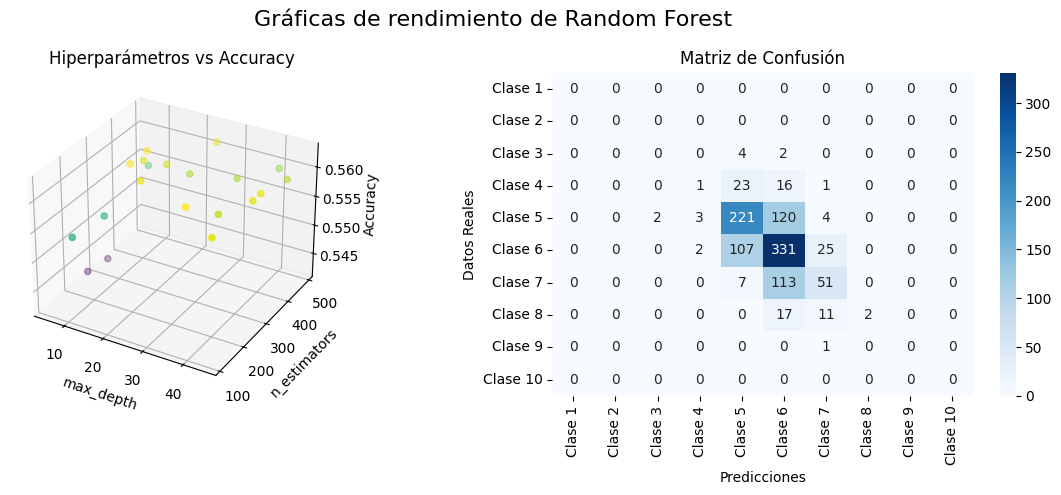

In [ ]:
plot_resultados(random_RF, X_test, y_test, nombre_modelo = 'Random Forest')

***
<span style="font-family:Cambria Math">

Un aspecto curioso del modelo Random Forest es que los cambios en **`accuracy`** entre distintos niveles de hiperparámetros no siguen un patrón gradual, sino que parecen caóticos. Esto dificulta la identificación de una tendencia clara para ajustar los hiperparámetros y mejorar el **`accuracy`**.

Por otro lado, en la matriz de confusión, este modelo muestra buenos resultados en la clasificación de las clases intermedias. Aunque aún confunde algunas clases extremas, lo hace con valores más cercanos, lo que representa una mejora con respecto a modelos anteriores.

</span>


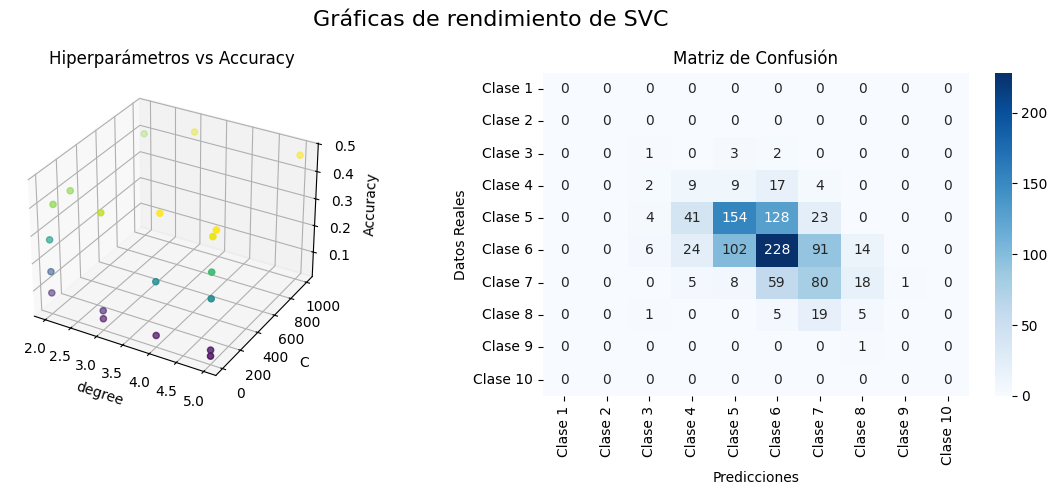

In [ ]:
plot_resultados(random_SVC, X_test, y_test,nombre_modelo = 'SVC')

***
<span style="font-family:Cambria Math">

El modelo SVC presenta una matriz de confusión similar a la obtenida con Random Forest, aunque con resultados ligeramente menos satisfactorios.

Nuevamente, no se identifica un patrón claro en los hiperparámetros que permita determinar con certeza qué ajustes realizar para mejorar el **`accuracy`**. Sin embargo, podría tener sentido ajustar el hiperparámetro **`C`** para evaluar su impacto en el desempeño del modelo.

</span>

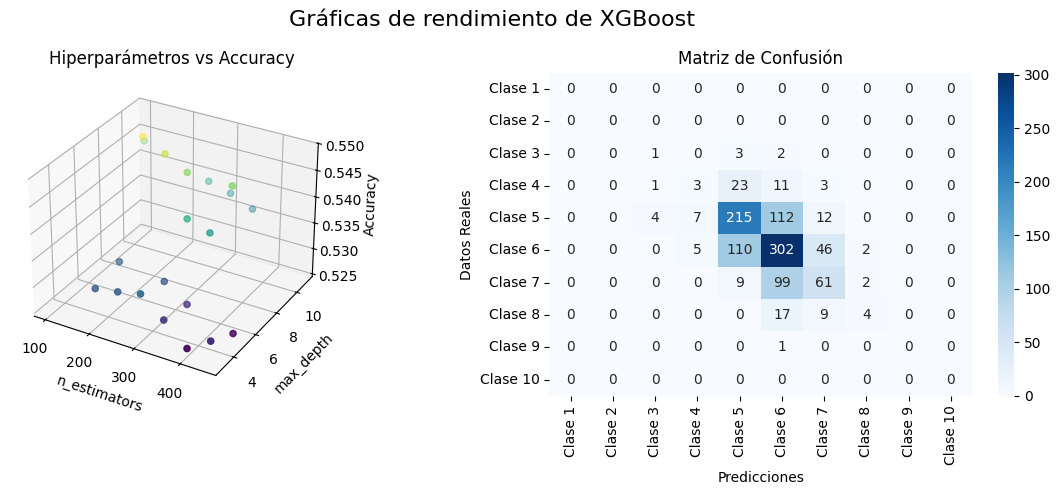

In [ ]:
plot_resultados(random_XGB, X_test, y_test_enc,XGBoost=True,nombre_modelo = 'XGBoost')

***
<span style="font-family:Cambria Math">

El modelo XGBoost muestra resultados satisfactorios en la matriz de confusión. Aunque el **`accuracy`** sigue siendo relativamente bajo, es importante destacar que los errores de clasificación ocurren en clases más cercanas a la real. Adicionalmente, el **`accuracy`** más alto parece converger de una manera menos caotica que los modelos anteriores. Marcando una tendencia a tener mayor número de estimadores (árboles) pero también tener una profundidad mayor.

En otras palabras, aunque el modelo tiene un desempeño similar en términos de **`accuracy`**, sus predicciones tienden a estar más alineadas con la clase correcta en comparación con modelos previos.

</span>

In [ ]:
display(pd.DataFrame(dicc_resultados_val))

,modelo,Accuracy,Recall,F1-score,Tiempo de entrenamiento,Hiper-parámetros
0,Regresión Logística,0.503228,0.503228,0.496427,10 min 45.29 s,"{'C': 4.815922800664158, 'penalty': 'l1'}"
1,Red Neuronal,0.758265,0.758265,0.749747,15 min 8.73 s,"{'hidden_layer_sizes': (33, 22, 10), 'alpha': ..."
2,K-Vecinos,0.841996,0.841996,0.831457,36.46 s,"{'n_neighbors': 1, 'metric': 'manhattan'}"
3,Árbol de Decisión,0.752653,0.752653,0.745605,17.92 s,"{'max_depth': 17, 'criterion': 'entropy'}"
4,Random Forest,0.562529,0.562529,0.255649,3 min 58.46 s,"{'max_depth': 15, 'n_estimators': 276}"
5,SVC,0.470618,0.470618,0.260441,48 min 40.12 s,"{'degree': 4, 'C': 46.41588833612773}"
6,XGBoost,0.548424,0.548424,0.273139,3 min 1.58 s,"{'n_estimators': 150, 'max_depth': 9}"


In [ ]:
display(pd.DataFrame(dicc_resultados_test))

,modelo,Accuracy_Test,Recall_Test,F1-Score
0,Regresión Logística,0.305451,0.305451,0.008163
1,Red Neuronal,0.416353,0.416353,0.004665
2,K-Vecinos,0.458647,0.458647,0.005131
3,Árbol de Decisión,0.420113,0.420113,0.007524
4,Random Forest,0.569549,0.569549,0.002154
5,SVC,0.448308,0.448308,0.001016
6,XGBoost,0.550752,0.550752,0.298937


***
<span style="font-family:Cambria Math">

Para finalizar esta sección, realizamos un análisis gneral de los principales indicadores de rendimiento de cada modelo.

Durante la fase de validación, al contar con conjuntos balanceados mediante técnicas como **`SMOTE`** o ajustes de peso intrínsecos a los modelos, tenía sentido priorizar la métrica **`accuracy`**, ya que esta proporciona una visión general del desempeño del clasificador. Sin embargo, en la fase de *test*, donde los datos reflejan mejor la distribución real, es crucial dar mayorr importancia a métricas como el *recall ponderado* y el *F1-score macro*.

Estas métricas permiten evaluar si el modelo está sesgado hacia ciertas clases y si mantiene un buen equilibrio en su capacidad de predicción. En particular:
- **Recall ponderado**: Garantiza que el modelo no ignore clases minoritarias al considerar la proporcion de cada clase en los datos.
- **F1-score macro**: Promedia el desempeño de todas las clases sin ponderar por frecuencia, lo que es útil en conjuntos desbalanceados.

Se observa que las métricas obtenidas en la fase de validación son significativamente diferentes a las obtenidas en *test*. Esta diferencia sugiere que algunos modelos pueden estar sufriendo de *overfitting*, es decir, han aprendido patrones específicos de los datos de entrenamiento pero no logran generalizar correctamente.

El *overfitting* puede llevar a un aumento en la varianza, lo que significa que pequeños cambios en los datos de prueba pueden generar resultados muy distintos. Este comportamiento suele ocurrir en modelos excesivamente complejos, como redes neuronales profundas o algoritmos con una alta cantidad de hiperparámetros no regulados.

Este análisis finala destaca la importancia de utilizar múltiples métricas para evaluar modelos y evitar sesgos que puedan comprometer su aplicabilidad en escenarios reales.

</span>


***
<span style="font-family:Cambria Math">

# 6. Análisis de resultados y conclusiones


Podríamos resumir que, la eficacia de un modelo no solo depende del **`accuracy`**, sino de la calidad y representatividad de los datos de entrenamiento, la correcta selección del algoritmo, un entrenamiento efectivo y una evaluacion rigurosa. La elección de un modelo debe considerar todo el flujo de *machine learning*, evitando decisiones basadas únicamente en métricas aisladas.

A partir de las tablas obtenidas en la sección anterior, se pueden destacar las siguientes observaciones:

- **SVC**: Es el modelo con mayor tiempo de entrenamiento y peor desempeño en casi todas sus métricas. Dado que la técnica del *Kernel* proyecta los datos en espacios de mayor dimensión, el costo computacional es alto, sin que ello se refleje en un rendimiento significativo. En la fase de *test*, su desempeño sigue siendo mediocre, por lo que es descartable en este caso.

- Modelos con alto **`accuracy`** en validación pero caída en *test*:  
  - Algoritmos como *K-Vecinos*, *MLP* y Árbol de Decisión mostraron buenos resultados en la fase de validación, pero su desempeño decayó en *test*, lo que sugiere sobreajuste (*overfitting*).  

XGBoost en general mostró el mejor desempeño en términos de precisión y f1-score. Esto se puede deber a que:
1. Utiliza árboles de decisión secuenciales con *gradiente boosting*, mejorando su capacidad de generalización.
2. Incorpora regularización (L1 y L2), reduciendo el sobreajuste.
3. Es más eficiente en términos de memoria y tiempo de entrenamiento comparado con Random Forest.

En problemas como el planteado en este examen, es muy importante controlar la complejidad del modelo para evitar este problema. Aumentar capas en redes neuronales, profundidad en árboles de decisión o grados en regresiones polinómicas puede llevar al **overfitting** si no se controla adecuadamente.

Frente a todos los algoritmos evaluados, se resaltan dos como los más consistentes. Random Forest y *XGBoost* están diseñados para reducir el problema de varianza, evitando la sobreadaptación a los datos de entrenamiento.

- En validación, sus métricas pueden parecer "moderadas", pero en test se mantienen estables, lo que indica mejor capacidad de generalización.
- Eficiencia computacional: A pesar de su capacidad de aprendizaje más robusta, estos modelos fueron eficientes en términos de tiempo de entrenamiento.
- *XGBoost* en particular destaca por ser el único con un **`F1-Score`** superior a 0.1, lo que indica un mejor balance entre precisión y recall en todas las clases.

si bien ningún modelo es realmente el mejor, en el contexto de este experimento y con el *pipeline* utilizado, *XGBoost* se posiciona como el mejor candidato para la clasificación de la calidad del vino. Su estabilidad entre validación y prueba, junto con su eficiencia computacional, lo hacen una opción decente.

Sin embargo, sería recomendable explorar ajustes adicionales, como optimización de hiperparámetros más exhaustiv, *feature engineering* o  más técnicas de *ensamble* para mejorar aún más los resultados.
</span>

In [ ]:
#Elección del mejor modelo
mejor_modelo = dicc_modelos['XGBoost']

***
<span style="font-family:Cambria Math">

## 6.1 Ejercicio Didáctico: Uso de la Cota de Chernoff

Para finalizar, realizamos un ejercicio didáctico utilizando las cotas de chernoff. Estas cotas nos permiten estimar la probabilidad de que una métrica, como el **`accuracy`**, se desvíe significativamente de su valor esperado. En términos generales, la Cota de Chernoff nos ayuda a calcular:

- Cuantos datos se necesitan para garantizar que la estimación de una métrica no se desvíe en más de un *epsilon* del valor real.
- La probabilidad (1 - *delta*) de que esta estimación sea correcta.

En este caso, usamos la Cota de Chernoff para evaluar la estabilidad del **`accuracy`** de *XGBoost* obtenido anteriormente

En los resultados anteriores, observamos que:
- XGBoost mostró un F1-score más alto que otros modelos, lo que indica una mejor distribución de predicciones entre clases**.
- Su **`accuracy`** en *test* no varió drásticamente en comparación con validación, lo que sugiere baja varianza y buena capacidad de generalización.

En ese orden de ideas, queremos cuantificar qué tan probable es que su **`accuracy`** se desvíe más de un 5% o 10% por encima de su valor esperado [¹⁰].
</span>



In [ ]:
from scipy.stats import bernoulli
dicc_resultados_test_df = pd.DataFrame(dicc_resultados_test)
accuracy_XGB = dicc_resultados_test_df.loc[dicc_resultados_test_df['modelo'] == 'XGBoost', 'Accuracy_Test']

n = X_train.shape[0]
p_real = accuracy_XGB.values[0]

def cota_chernoff(p_real, delta, n):
    return np.exp(- (delta ** 2) * p_real * n / 3)

# Evaluar desvíos del 10% y 20% por encima de la media esperada
deltas = [0.05, 0.1]
cota_chernoffs = [cota_chernoff(p_real, d, n) for d in deltas]
print(f"La probabilidad de que el accuracy se desvíe un {deltas[0]*100}% por encima de lo esperado es de {cota_chernoffs[0]:.10f}")
print(f"La probabilidad de que el accuracy se desvíe un {deltas[1]*100}% por encima de lo esperado es de {cota_chernoffs[1]:.10f}")

La probabilidad de que el accuracy se desvíe un 5.0% por encima de lo esperado es de 0.1419308356
La probabilidad de que el accuracy se desvíe un 10.0% por encima de lo esperado es de 0.0004057953


***
<span style="font-family:Cambria Math">

Este resultado parece indicar, que en un escenario ideal, la probabilidad de que el **`accuracy`** real se diferencie en **10%** del **`accuracy`** obtenido en este ejercicio práctico es del **0.04%**. Es decir que para datos futuros este modelo no debería tener una diferencia de desempeño significativa. Por otro lado, el buen desempeño y consistencia del **`accuracy`** en futuros datos siempre va a depender de cuán generalizable es el modelo. Ya se mencionó que parte de la razón por la que se escoge el modelo de *XGBoost* es por su buena capacidad de generalización.
</span>

***
<span style="font-family:Cambria Math">

# 7. Referencias
</span>

***
<span style="font-family:Cambria Math">

[¹] **Solución Taller 1, Curso ML No Supervisado**  
Disponible en: [Coursera - Machine Learning No Supervisado](https://www.coursera.org/learn/maia-machine-learning-no-supervisado/supplement/fXisI/solucion-al-problema-practicon)

[²] **Ídem.**

[³] **Taller 2, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/oqZpF/efecto-de-los-datos-en-la-generacion-de-modelos)

[⁴] **Lección 1, Semana 7, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/MFHfh/clasificacion-binaria-no-balanceada-con-y-sin-costos)

[⁵] **Lección 1, Semana 4, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/iMjb1/clasificacion-y-regresion-simple-diferentes-modelos/lab?path=%2Fnotebooks%2Frelease%2FSemana4Leccion1%2FSemana4Leccion1.ipynb)

[⁶] **Taller 6, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/a9xeR/problema-de-clasificacion-usando-un-ensamble-de-arboles)

[⁷] **Taller 4, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/lI87o/seleccion-de-modelo-y-regularizacion-en-redes-neuronales)

[⁸] **Lección 1, Semana 6, Curso ML Supervisado**  
Disponible en: [Coursera - Machine Learning Supervisado](https://www.coursera.org/learn/maia-machine-learning-supervisado/programming/t5nSQ/problema-de-clasificacion-con-random-forest)

[⁹] **Ídem.**

[¹⁰] **Cotas de Chernoff**  
Disponible en: [Wikipedia - Cotas de Chernoff](https://es.wikipedia.org/wiki/Cotas_de_Chernoff)

</span>





